<b><h1>Online Payment Fraud Detection</h1></b>

In [ ]:
%pip install kagglehub pandas matplotlib seaborn xgboost numpy scikit-learn

In [ ]:
########## Load dataset using Kaggle Hub ##############
import kagglehub
import os
import pandas as pd

path = kagglehub.dataset_download('jainilcoder/online-payment-fraud-detection')
print("Dataset downloaded to:", path)
csv_file_path = os.path.join(path, 'onlinefraud.csv')
ds = pd.read_csv(csv_file_path)

In [ ]:
########### Load dataset from local storage ############
#### CSV file in same directory
# import pandas as pd
# ds = pd.read_csv('onlinefraud.csv')

In [2]:
########## Creating Dataframe #############
import pandas as pd
df = pd.DataFrame(ds)

In [ ]:
######### Dataframe info ##############
print("Shape:",df.shape)
# df.info()
df.head()

Shape: (6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
########## Dataframe describe ##########
# df.describe()
# df[df["step"] == 0].count()
both_have = df[df['newbalanceDest'].notna() & df['oldbalanceDest'].notna()]
one_missing = df[df['newbalanceDest'].isna() ^ df['oldbalanceDest'].isna()]
print("Rows where both have values:", len(both_have))
print("Rows where one is missing:", len(one_missing))
print("Total rows:", len(df))



Rows where both have values: 6362620
Rows where one is missing: 0
Total rows: 6362620


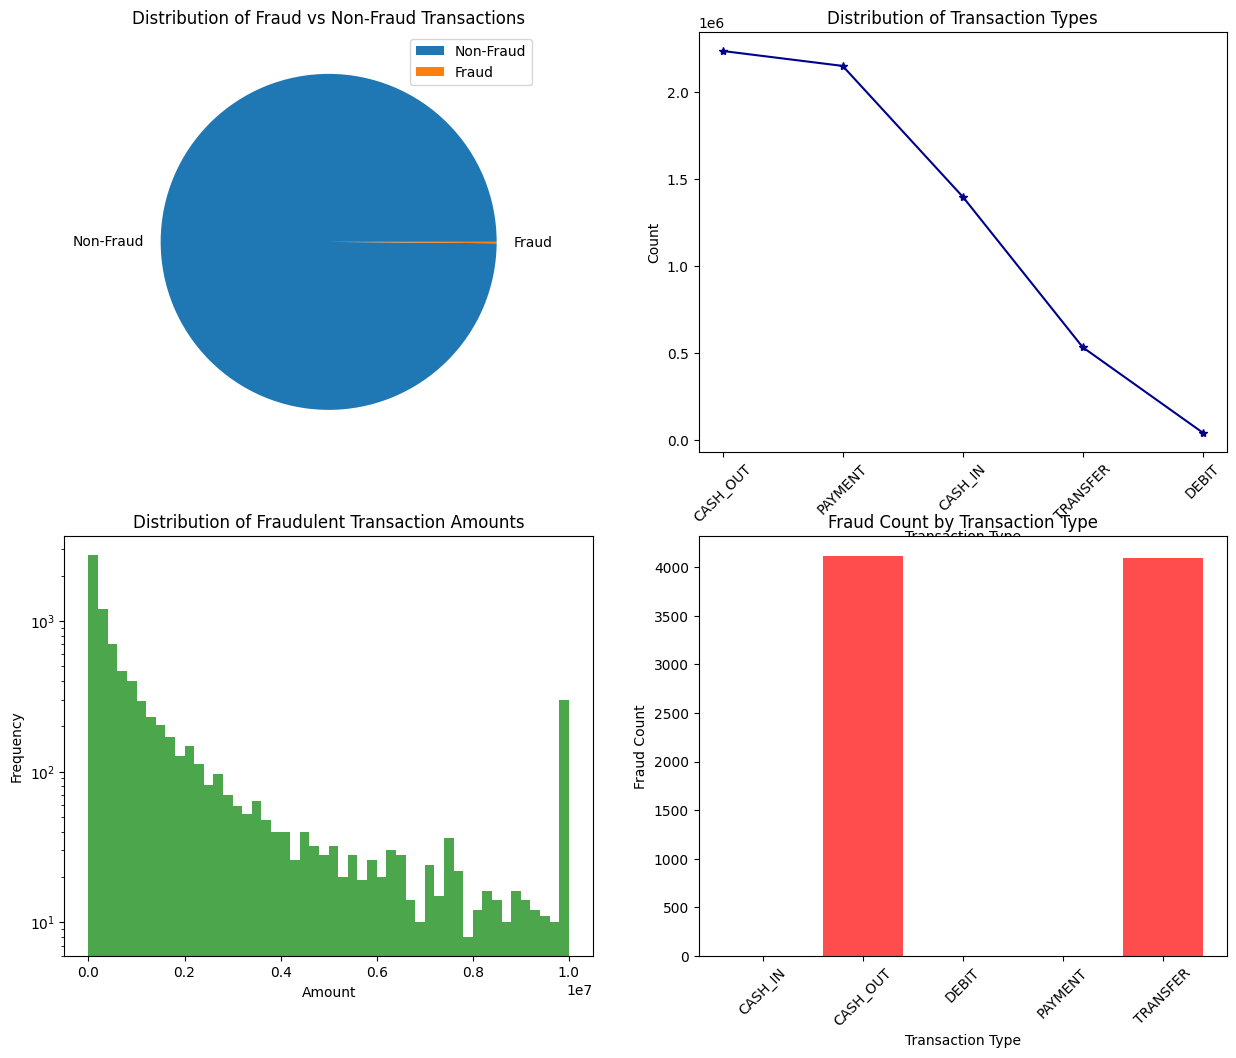

In [5]:
########## Data Visualization ##########
import matplotlib.pyplot as plt

# Create subplots for multiple visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Distribution of Fraud vs Non-Fraud transactions
fraud_counts = df['isFraud'].value_counts()
axes[0, 0].pie(fraud_counts.values, labels=['Non-Fraud', 'Fraud'])
axes[0, 0].set_title('Distribution of Fraud vs Non-Fraud Transactions')
axes[0, 0].legend()

# 2. Transaction types distribution
type_counts = df['type'].value_counts()
axes[0, 1].plot(type_counts.index, type_counts.values, color='darkblue', marker='*')
axes[0, 1].set_title('Distribution of Transaction Types')
axes[0, 1].set_xlabel('Transaction Type')
axes[0, 1].set_ylabel('Count')
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Amount distribution (log scale due to wide range)
axes[1, 0].hist(df[df['isFraud'] == 1]['amount'], bins=50, alpha=0.7, color='green')
axes[1, 0].set_title('Distribution of Fraudulent Transaction Amounts')
axes[1, 0].set_xlabel('Amount')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_yscale('log')

# 4. Fraud by transaction type
fraud_by_type = df.groupby('type')['isFraud'].sum()
axes[1, 1].bar(fraud_by_type.index, fraud_by_type.values, color='red', alpha=0.7)
axes[1, 1].set_title('Fraud Count by Transaction Type')
axes[1, 1].set_xlabel('Transaction Type')
axes[1, 1].set_ylabel('Fraud Count')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.show()


In [ ]:
df_processed = pd.get_dummies(df, columns=['type'], drop_first=True)

X = df_processed.drop(columns=['isFraud', 'nameOrig', 'nameDest'])
y = df_processed['isFraud']
print(f"{X.head()}\n{y.head()}")

   step    amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0     1   9839.64       170136.0       160296.36             0.0   
1     1   1864.28        21249.0        19384.72             0.0   
2     1    181.00          181.0            0.00             0.0   
3     1    181.00          181.0            0.00         21182.0   
4     1  11668.14        41554.0        29885.86             0.0   

   newbalanceDest  isFlaggedFraud  type_CASH_OUT  type_DEBIT  type_PAYMENT  \
0             0.0               0          False       False          True   
1             0.0               0          False       False          True   
2             0.0               0          False       False         False   
3             0.0               0           True       False         False   
4             0.0               0          False       False          True   

   type_TRANSFER  
0          False  
1          False  
2           True  
3          False  
4          False  
0    0
1

In [7]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np

# Check class distribution before balancing
print("Original class distribution:")
print(y.value_counts())
print(f"Fraud percentage: {(y.sum() / len(y)) * 100:.3f}%")

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

print("\nAfter SMOTE balancing:")
print(f"X_balanced shape: {X_balanced.shape}")
print(f"y_balanced distribution: {np.bincount(y_balanced)}")

# Split the balanced dataset
x_train, x_test, y_train, y_test = train_test_split(X_balanced, y_balanced, random_state=42, test_size=0.25, stratify=y_balanced)

print(f"\nTraining set shape: {x_train.shape}")
print(f"Test set shape: {x_test.shape}")
print(f"Training set class distribution: {np.bincount(y_train)}")
print(f"Test set class distribution: {np.bincount(y_test)}")
print("Done")

Original class distribution:
isFraud
0    6354407
1       8213
Name: count, dtype: int64
Fraud percentage: 0.129%

After SMOTE balancing:
X_balanced shape: (12708814, 11)
y_balanced distribution: [6354407 6354407]

Training set shape: (9531610, 11)
Test set shape: (3177204, 11)
Training set class distribution: [4765805 4765805]
Test set class distribution: [1588602 1588602]
Done


In [ ]:
########## XGBoost Model Training ##########

# Calculate scale_pos_weight for handling any remaining imbalance
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
print(f"Scale pos weight: {scale_pos_weight}")

# Initialize XGBoost classifier with optimized parameters
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    verbosity=1
)

# Train the model
print("Training XGBoost model...")
xgb_model.fit(x_train, y_train)

# Make predictions
y_pred = xgb_model.predict(x_test)
y_pred_proba = xgb_model.predict_proba(x_test)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"\nModel Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

# Detailed classification report
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred))

Scale pos weight: 1.0
Training XGBoost model...

Model Performance:
Accuracy: 0.9961
ROC AUC Score: 0.9999

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00   1588602
           1       0.99      1.00      1.00   1588602

    accuracy                           1.00   3177204
   macro avg       1.00      1.00      1.00   3177204
weighted avg       1.00      1.00      1.00   3177204



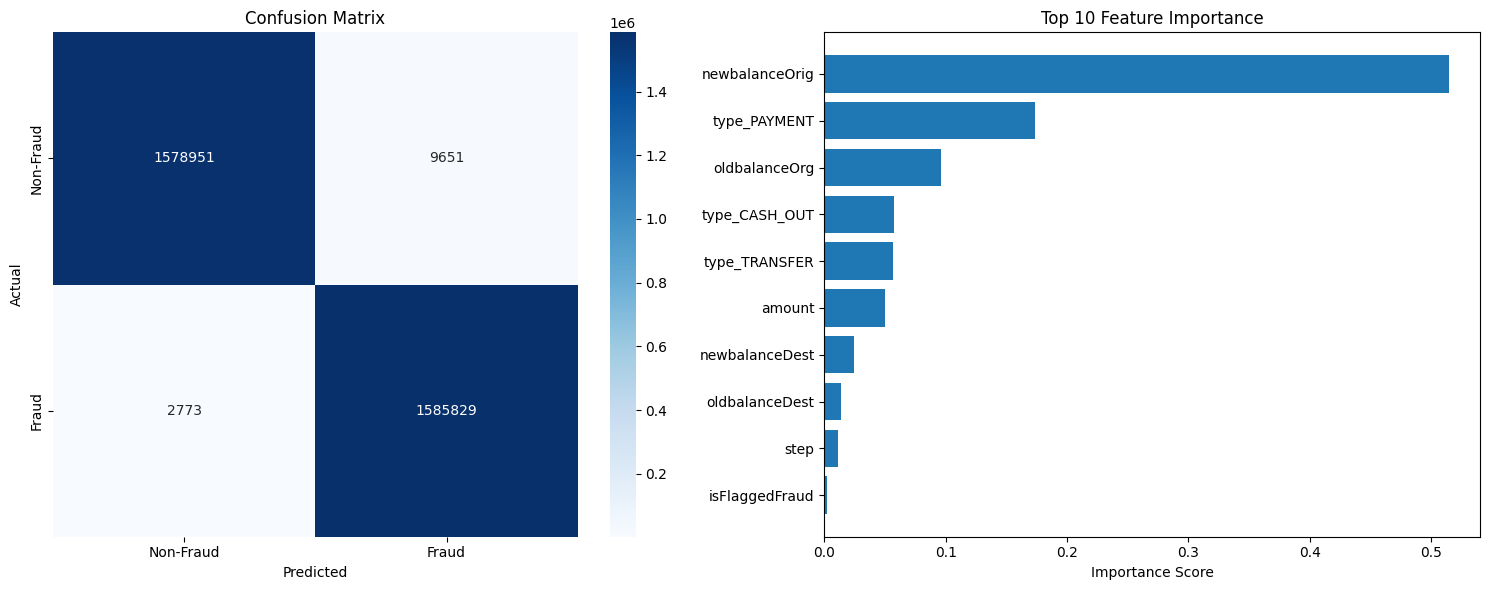


Confusion Matrix Details:
True Negatives: 1578951
False Positives: 9651
False Negatives: 2773
True Positives: 1585829

Detailed Metrics:
Precision: 0.9940
Recall (Sensitivity): 0.9983
F1-Score: 0.9961
Specificity: 0.9939

Top 5 Most Important Features:
type_TRANSFER: 0.0562
type_CASH_OUT: 0.0576
oldbalanceOrg: 0.0962
type_PAYMENT: 0.1732
newbalanceOrig: 0.5145


In [10]:
########## Model Evaluation and Visualization ##########
import seaborn as sns

# Create confusion matrix
cm_matrix = confusion_matrix(y_test, y_pred)

# Create subplots for visualizations
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 1. Confusion Matrix Heatmap
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_xticklabels(['Non-Fraud', 'Fraud'])
axes[0].set_yticklabels(['Non-Fraud', 'Fraud'])

# 2. Feature Importance
feature_importance = xgb_model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=True)

# Plot top 10 most important features
top_features = importance_df.tail(10)
axes[1].barh(top_features['feature'], top_features['importance'])
axes[1].set_title('Top 10 Feature Importance')
axes[1].set_xlabel('Importance Score')

plt.tight_layout()
plt.show()

# Print confusion matrix details
tn, fp, fn, tp = cm_matrix.ravel()
print(f"\nConfusion Matrix Details:")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

# Calculate precision, recall, and F1-score manually
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"\nDetailed Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")
print(f"Specificity: {tn / (tn + fp):.4f}")

print(f"\nTop 5 Most Important Features:")
for i, row in importance_df.tail(5).iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")

In [ ]:
############# Saving Model as JSON ##############
import os 

xgb_model.save_model("model.json")

# Get size
print("Model size (MB):", os.path.getsize("model.json") / (1024 * 1024))

Model size (MB): 0.5277471542358398


In [ ]:
########## Model Testing Block ##########

def predict_transaction(input_dict):
    input_df = pd.DataFrame([input_dict])
    # Align columns with training data (handle missing dummy columns)
    for col in X.columns:
        if col not in input_df.columns:
            input_df[col] = 0
    input_df = input_df[X.columns]  # Ensure correct column order

    # Predict
    pred = xgb_model.predict_proba(input_df)[0][1]
    if pred > 0.4: 
        return "Fraud"
    else:
        return "Legit"
    

sample_input = {
    'step': 2000,
    'amount': 150000,
    'oldbalanceOrg': 200000,
    'newbalanceOrig': 50000,
    'oldbalanceDest': 0,
    'newbalanceDest': 150000,
    'type_CASH_OUT': 1,
    'type_DEBIT': 0,
    'type_PAYMENT': 0,
    'type_TRANSFER': 0
}

result = predict_transaction(sample_input)
print("Prediction:", result)

fraud_input = {
    "step": 1,
    "amount": 181,
    "oldbalanceOrg": 181,
    "newbalanceOrig": 0,
    "oldbalanceDest": 0,
    "newbalanceDest": 0,
    'type_CASH_OUT': 0,
    'type_DEBIT': 0,
    'type_PAYMENT': 0,
    'type_TRANSFER': 1
}

result = predict_transaction(fraud_input)
print("Prediction:",result)


Prediction: Legit
Prediction: Fraud
